In [1]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
using ForwardDiff
using Statistics
using Interpolations
# using DSP

using PyPlot
# using PyCall
# using CSV

  Activating project at `~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB/sonde`


In [36]:
# utility functions; extend matplotlib

# use numpy masking for missing
using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

moving_average

In [3]:
module VaporSat

using ForwardDiff

export qsat, dqsdT, dlnqsdT
export Twet_autodiff

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

"latent heat of water vapor"
LvK(TempK) = L0 + (Cpv-Cw) * (TempK-273.0)

# functions
"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"T [C]; supplying TK [Kelvin] by keyword ignores positional T"
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # converts es to Pa
end

"""
qsat(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qsat [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
qsat(p,T) = RdoRv*es(T,p) / (p + (RdoRv-1)*es(T,p))

"dqsdT(p,T[C]) derivative of qsat with respect to T at p,T by autodiff of Bolton's qsat"
dqsdT(p,T) = ForwardDiff.derivative(t -> qsat(p,t), T)
dlnqsdT(p,T) = ForwardDiff.derivative(t -> log(qsat(p,t)), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qsat(pa, Ta)
# Twet_autodiff(Ta, rh*qsat(pa, Ta-C), pa) 

end # module VaporSat

┌ Warning: Replacing docs for `Main.VaporSat.es :: Union{Tuple{Any}, Tuple{Any, Any}}` in module `Main.VaporSat`
└ @ Base.Docs docs/Docs.jl:243


Main.VaporSat

In [4]:
VaporSat.dlnqsdT(1e5,25.0) # 6 %/K at 25 °C

0.06034205388324553

In [5]:
# functions for thermodynamics

using .VaporSat
# exports dqsdT
# overloads some methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

dqsatdz_moistad

In [6]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "./data"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")
ncfile[1]

"EUREC4A_RonBrown_Vaisala-RS_L2_v3.0.0.nc"

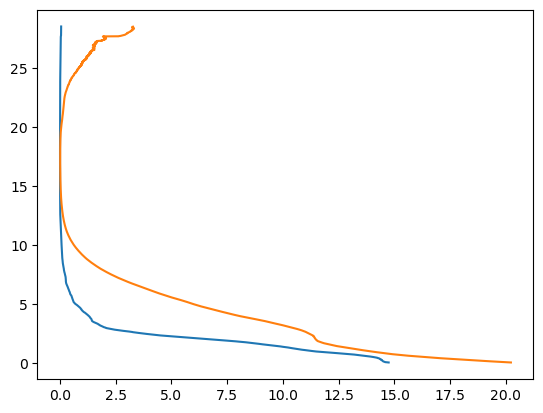

In [7]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

# plot potential temperature
clf()
[ plot(ds[:theta][:,i], z/1e3, color="c", linewidth=0.2) for i in axes(ds[:theta][:,:],2) ]
plot(thm, z/1e3, color="tab:blue")
ylim(0, 4)
xlim(295, 320)
title("potential temperature (K)")
gcf()

clf()
plot(qm*1e3, z/1e3) # g/kg
plot(qs*1e3, z/1e3)
gcf()

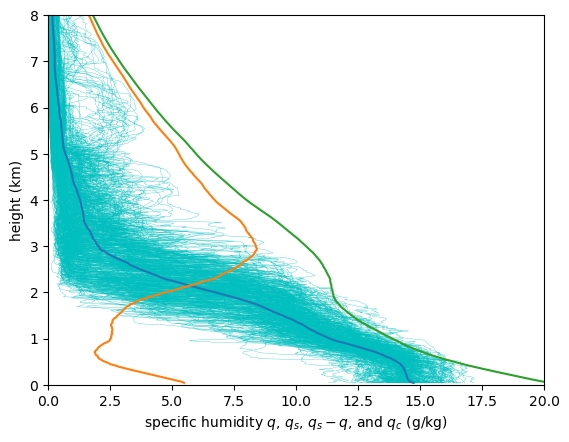

In [8]:
# plot humidities

clf()
[ plot(1e3*ds[:q][:,i], z[:]/1e3, color="c", linewidth=0.2) for i in axes(ds[:q][:,:],2) ]
plot(1e3*qm, z[:]/1e3, color="tab:blue")
plot(1e3*qs, z[:]/1e3, color="tab:green")
plot(1e3*(qs.-tmean(:q)), z[:]/1e3, color="tab:orange")
# plot(1e3*ql_eq[icb:end], z[icb:end]/1e3, color="tab:purple")
ylim(0, 8)
xlim(0, 20.0)
xlabel("specific humidity \$q\$, \$q_{s}\$, \$q_{s}-q\$, and \$q_c\$ (g/kg)")
ylabel("height (km)")
ax = gca()
# ax.set_aspect(1) # don't

# deprecated plot
# savefig("humidity_mean_diff.png")
# savefig("humidity_mean_diff.svg")
# savefig("humidity_mean_diff.eps")
gcf()

In [9]:
# set parameters for cloud & flux model, and control case
ae = 1.5e-3
x = 0.39 # was 0.25
# pcp_coeff = x*ae # 1/m
# entr_coeff = (1-x) * ae

# deprecated: equilibrium cloud liquid
# ql_eq = -dqsatdz_moistad.(pm, tam) ./ (entr_coeff + pcp_coeff)

0.39

## Old comment on prototype flux calculation.

Suggest use Δq = 2 g/kg.

Saturated updrafts above 1.7 km will be much moister than the environment 
(by up to 8 g/kg!), but we expect entrainment dries them strongly there, 
so for simplicity 
use uniform Δq = 2 g/kg.

Combined with temperature stability, entrainment of dry air at 3 km is part of a buoyancy valve that inhibits deeper convection.
Some updrafts may be sufficiently moist somewhere to push through the inversion above 3 km,
but these are not the trade cumulus clouds we're interested in modeling here.

## Prototype trade cumulus convective mass flux inferred from moisture balance

See [massflux.md](./massflux.md)

We use net surface evaporation $(E-P)_0$ = 150 W m $^{-2} \sim $ 5.5 mm day $^{-1}$ net evaporation, which gives a mass flux that approaches 0 at 10 km.

Figure MASSFLX shows the mass flux computed from equation using the mean specific humidity profile from the *Ronald H. Brown* radiosondes and the subsidence profile ($-\overline{w}$). 


![MASSFLX](massflux_atomic.png)

Figure MASSFLX. Specific humidity (green), subsidence (blue dashed), and convective mass flux (orange) for the trade cumulus boundary layer from moisture balance (equation ). A mass flux velocity $w^*$ = 25 mm s $^{-1}$ is equivalent to mean updrafts of 2.5 m s $^{-1}$ occupying 1% of the area.

In [10]:
# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

divg = 1.0e-6 # 1/s
zi = 3.0e3    # m
# epsilon=0.5
# Δq=0.002      # kg/kg
Δq = qs .- qm # depends on environment only

# vertical velocity (m/s)
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0

# derivatives
dz = 10.0
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs
# cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon))

# total large scale drying, add advection term in lower atm
A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 
# idealized LS drying


# epsilon now represents entrainment, so this is commented out
#=
function massflux(q, z; dz=z[2]-z[1], zi=zi, epsilon=epsilon, divg=divg, Δq=Δq)
    inv = findlast(z .<= zi)
    intqdz = cumsum(q.*dz)
    intqdz[(inv+1):end] .= intqdz[inv]
    -divg * ( intqdz .- q.*min.(z, zi) ) / (Δq * (1-epsilon))
end
# wstar is mass flux, represented by capital W in the ms text
# wstar = massflux(qm[ii], z[ii]; dz=z[ii].-z[ii.-1]) .+ EmP/Δq
wstar = -cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon)) .+ EmP/Δq # numerical integral goes to 0 at sfc.
netevap = 86400 * EmP*(1.18/1e3) # 5.5 mm / day
=#




3099-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
  -1.7130481915473937e-8
  -1.703269395083189e-8
  -1.694246646285057e-8
  -1.6767581752836703e-8
  -1.677824071407318e-8
  -1.6769396849274636e-8
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [11]:
# set up prototype mass flux calculation

# L = 2.4e6
rhosfc = 1.16 # kg/m^2

ztop=4e3
# Tm = mean(skipmissing(tmean(:ta)[ds[:alt][:].<=ztop])); # mean Cu layer temperature
n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))
# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2

# EmP = 150.0/(1.16*L) # <w'q'>_0 kinematic sfc E-P, Hevap/(ρair*L) ≈ 0.031 mm/s = 111 mm/h
# EmP = 135.0/(1.16*L) # <w'q'>_0 kinematic sfc E-P, Hevap/(ρair*L)

25.439572131025795

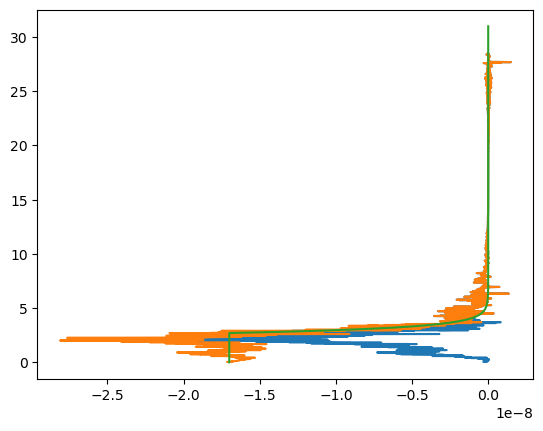

In [12]:
# set flux, vertical coordinate

icb = findfirst(z.>=600) # cloud base index

Ecb = 145 # this satisfies the condition that 
Fcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # total flux at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
F = similarmissing(qm)

# F[icb:end] = Fcb .+ vcat(0, cumsum( A[icb:end] ) * dz)
Aideal = -1.7e-8 .* min.(1, exp.(-(z.-2.7e3)./500))

# plot large scale drying
clf()
plot(-wdqdz, z[1:end-1]/1e3)
plot(A, z[1:end-1]/1e3)
plot(Aideal, z/1e3)
gcf()

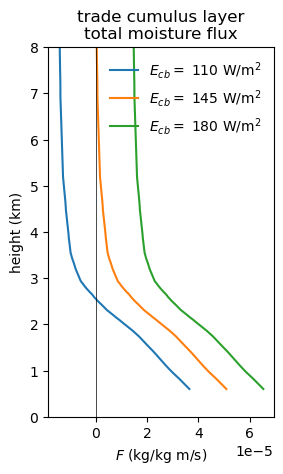

In [13]:
# plot TOTAL moisture flux for some cloud base vapor fluxes
clf()
subplot(1,2,1)
for Ecb = 110:35:180 # W/m^2 --> F(5km)=0
    Fcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # total flux at cloud base
    F = similarmissing(qm)
    # F[icb] = Fcb # total flux at cloud base
    # integrate total flux balancing subsidence
    F[icb:end] = Fcb .+ vcat(0, cumsum( A[icb:end] ) * dz)
    # F[icb] == Fcb # test
    # find trade cu top
    itop = findfirst(.!ismissing.(F) .&& F .< 0)

    plot(F[icb:end], z[icb:end]/1e3, label="\$E_{cb}=\$ $(Ecb) W/m\$^2\$")
end

plot([0,0], [0, 10], linewidth=0.5, color="k")
ylim([0, 8])
title("trade cumulus layer\ntotal moisture flux")
ylabel("height (km)")
xlabel("\$F\$ (kg/kg m/s)")
legend(frameon=false)
gcf()

In [14]:
# compute total flux F

# cloud base vapor flux initial condition
Ecb = 145 # E0 - 35; just the cloud vapor flux
Fcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
F = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
F[icb:end] = Fcb .+ vcat(0, cumsum( A[icb:end] ) * dz)
# F[icb] == Fcb # test
# trade cu top
# minfindfirst(F.<0)

# precipitation efficiency found iteratively to make F=Fcld=P=0 at ztop
# x=0.39

# icb = findfirst(.!ismissing.(F))
itop=lastindex(F)-1 


3099

In [15]:
# updraft total water and cloud water functions
# Updraft q_total, ql do not depend on F or Fcld.
# Below, mass flux W depends on q_total and Fcld.

# define parameters that functions depend on
# entrainment, autoconversion, and precipitation efficiency
# ae = 1.5e-3
# x = 0.39
# entr_coeff = (1-x) * ae
# pcp_coeff = x * ae

"qtilde=(1-x)*qm .+ x*qs intermediate environmental moisture function"
function q_tilde(qm, qs, x)
    (1-x)*qm .+ x*qs
end

"updraft q_total function"
function q_total(aedz, x, qs, qm; i0, qt0, stopattop=false)
    qtilde=(1-x)*qm .+ x*qs
    qt = copy(qtilde)
    qt[1:i0] .= qt0 # cloud base initial condition
    # in cloud
    for i in i0:length(qt)-1
        if qt[i] > qs[i] # in cloud
            a = aedz
            Q = 0.5*(qtilde[i]+qtilde[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif !stopattop   # above cloud
            a = (1-x)*aedz  # no precipitation sink
            Q = 0.5*(qm[i]+qm[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif stopattop  # above cloud, stop at cloud top
            qt[i+1] = -999
        end
    end
    return qt
end


q_total

In [16]:
# cloud flux Fcld functions
# ql needs to be calculate by the cloud functions already
"""
Iterates up cloud flux modifying Fcld with precipitation efficiency x and total flux F.
Must initialize cloud base Fcld[icb] first!
"""
function cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb=icb, itop=min(lastindex(F),findfirst(.!ismissing.(F) .&& F.<0)+20))
    Δq = qt .- qm
    c = @. -x*ae * ql / Δq * dz/2 # Q*dz stepping quantity # /2 added 2025 Aug 16
    # step Fcld through the trade Cu layer
    for i in icb:itop
        Fcld[i+1] = (F[i+1]-F[i] + Fcld[i]*(1+c[i])) / (1-c[i+1])                
    end
end

# not used
# "returns cloud flux as a function of precipitation efficiency"
# function cloudflux(x, ae, F, ql, qt, qm, icb, Fcld_cb=Fcb-P0/rhoL)
#     Fcld = similarmissing(F)
#     Fcld[icb] = Fcld_cb
#     cloudflux!(Fcld, x, ae, ae, F, ql, qt, qm, icb)
#     return Fcld
# end

# should cross 0 at ztop

# ql needs to be calculated by the cloud functions before calling cloudflux

# # precipitation functions
# precipflux(x, ae, F, ql, icb) = cloudflux(x, ae, F, ql, icb) .- F # Fcld - F
# precip_cb(x, ae, F, ql, icb) = precipflux(x, ae, F, ql, icb)[icb]

cloudflux!

In [37]:
"integrate precipitation down to cloud base by stepping"
function precipflux_down_sfc(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = 0.0 # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        # P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
        P = ( (1+c[i+1])*P + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    return P # at cloud base
end

"precipitation profile integrated downward from cloud top"
function precipflux_down(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = zeros(size(F)) # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
      # P    = ( (1+c[i+1])*P      + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] = NaN
    return P # precip flux vector
end

precipflux_down

In [38]:
# simple test of the precip computation

# parameters
ae = 3e-3
x = 0.5

# cloud base initial condition
icb = findfirst(z .>= 700)
qcb = qs[icb] # 0.0157

# compute clouds
qtilde = q_tilde(qm, qs, x)
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
itop = findlast(qt.-qs .> 0)
ql = max.(0, qt.-qs)

precipflux_down_sfc(x, ae, F, ql, qt, qm, istart=maximum(findall(ql.>0))+1, icb=icb) * rhoL
# W/m^2

4.262020480896899

In [39]:
# cloud base initial condition
zcb = 700
icb = findfirst(z .>= zcb)
qcb = qs[icb] # 0.0157

ist = findfirst(z .>= 2000)
ien = findfirst(z .<= 5000)

"terminate the cloud at ql=0"
findcloudtop(ql) = findfirst(ql .== 0 .&& z .> zcb )

"terminate the cloud either at ql=0 or at the elevated minimum ql in the trade inversion"
function findcloudtop(ql, ist,ien)
    itop = findfirst(ql .== 0 .&& z .> zcb )
    if isnothing(itop) # choose the minimum 
        itop = argmin(ql[ist:ien]) + ist - 1
    end
    itop
end

Fcld = similarmissing(F)
# parameter ranges
pcp_effic = 0:0.02:0.9         # precipitation efficiency
tot_sink  = 5e-4 : 1e-4 : 5e-3 # total sink rate α+ϵ
Pcb  = NaN .+ zeros(length(pcp_effic), length(tot_sink))
ztop = NaN .+ zeros(length(pcp_effic), length(tot_sink))
for ix in eachindex(pcp_effic)
    qtilde = q_tilde(qm, qs, x)
    for ia in eachindex(tot_sink)
        x  = pcp_effic[ix]
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        # itop = findlast(ql .> 0)
        itop = findcloudtop(ql)
        if !isnothing(itop)
            ztop[ix,ia] = z[itop]
            Pcb[ix,ia] = precipflux_down_sfc(x, ae, F, ql, qt, qm, istart=itop, icb=icb)
        end
    end
end

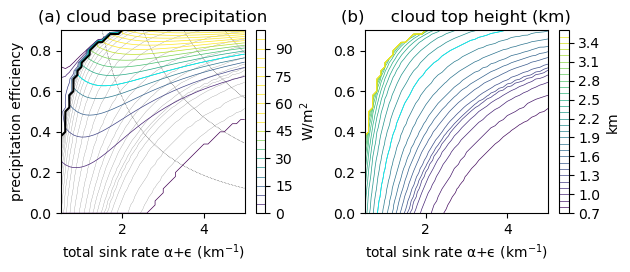

In [49]:
clf()
subplot(2,2,1)
contour(tot_sink*1e3, pcp_effic, tot_sink.*pd(pcp_effic), levels=4, colors="k", linewidths=0.4, linestyles=":")
contour(tot_sink*1e3, pcp_effic, ztop/1e3, levels=0.7:0.1:3.6, colors="gray", linewidths=0.2)
contour(tot_sink*1e3, pcp_effic, rhoL*Pcb, levels=0:5:100, vmin=0, vmax=50, linewidths=0.5)
cb = colorbar(); cb.set_label("W/m\$^2\$")
contour(tot_sink*1e3, pcp_effic, rhoL*Pcb, levels=25:25, colors="cyan", linewidths=0.5)
contour(tot_sink*1e3, pcp_effic, ztop/1e3, levels=3.6:3.6, colors="k")
# ylim([0, 0.8])
title("(a) cloud base precipitation")
xlabel("total sink rate α+ϵ (km\$^{-1}\$)")
ylabel("precipitation efficiency")
subplot(2,2,2)
contour(tot_sink*1e3, pcp_effic, ztop/1e3, levels=0.7:0.1:3.6, vmin=0.7, vmax=3.6, linewidths=0.5)
cb = colorbar(); cb.set_label("km")
contour(tot_sink*1e3, pcp_effic, ztop/1e3, levels=2:2, colors="cyan", linewidths=0.5)
xlabel("total sink rate α+ϵ (km\$^{-1}\$)")
title("(b)     cloud top height (km)")

tight_layout()
# [ savefig("precip_height.$(f)", format=f) for f in ("eps","png","svg","pdf") ]
gcf()

The cyan contours are P = 25 W/m^2 (near observed) and z_top = 2 km.

The dashed lines (left) are hyperbolae for constant autoconversion. Contours of constant P cross contours of autoconversion mostly --because integrated cloud water rather than autoconversion rate dominates the precipitation—, but P decreases for low enough autoconversion at the left.

(Maybe it's best to ignore what happens above and left of the top height bifurcation.)

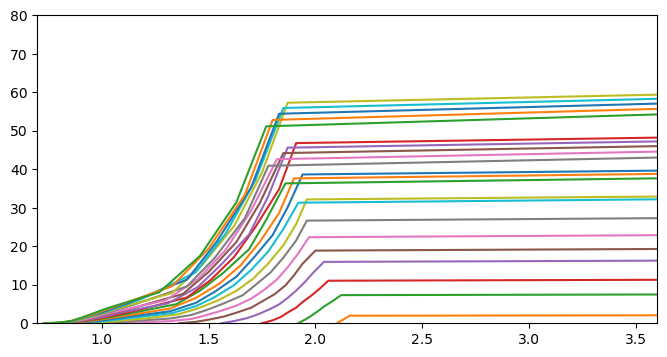

In [ ]:
clf()
plot(ztop/1e3, rhoL*Pcb)
xlim([0.7, 3.6])
ylim([0, 80])
ylabel("cloud base precipitation (W m\$^{-2}\$)")
xlabel("cloud top height (km)")
gcf()
# very sensitive to α+ϵ near the deep convective limit around 3.6 km

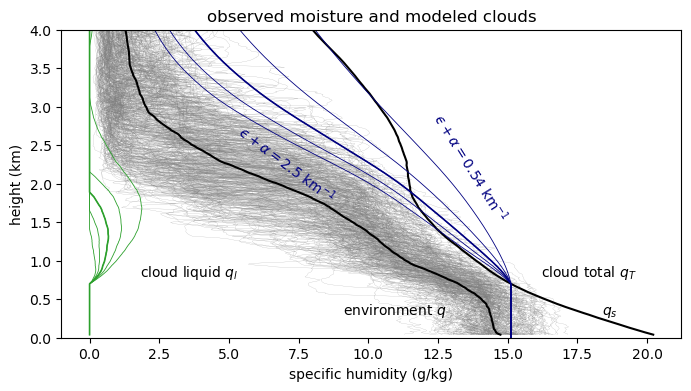

In [101]:
# compute best q_T, ql for control case
# some experimentation is done below

# parameters
ae = 1.5e-3
x = 0.43
entr_coeff = (1-x) * ae
pcp_coeff = x * ae
icb = findfirst(z .>= 700)

# qcb = 0.016 # cloud base initial condition
qcb = qs[icb] # 0.01568
qtilde = q_tilde(qm, qs, x)
# qtilde[1:54] .= qcb # cloud base initial condition
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb, qtilde=qtilde)
ql = max.(0, qt.-qs)

# plot result of cloud model
clf()
[ plot(1e3*ds[:q][:,i], z[:]/1e3, color="tab:gray", linewidth=0.1) for i in axes(ds[:q][:,:],2) ]
plot(1e3*qm, z/1e3, label=L"q", color="k")
plot(1e3*qs, z/1e3, label=L"q_s", color="k")
#for ae = 5e-3 .* (0.5:-0.1:0.1)
aeplot = vcat(5.4e-4, 1e-3 : 5e-4 : 2.5e-3)
for ae = aeplot
    qt_=q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb, qtilde=qtilde)
    plot(1e3*qt_, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=0.6)
    plot(1e3*max.(0,qt_.-qs), z/1e3, color="tab:green", linewidth=0.6)
end
# plot control case
plot(1e3*qt, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=1.2)
plot(1e3*ql, z/1e3, color="tab:green", linewidth=1.2)
ylim([0, 4])
ylabel("height (km)")
title("observed moisture and modeled clouds")#\nfor different entrainment\nand autoconversion sinks")
# legend(frameon=false)
xlabel("specific humidity (g/kg)")
text( 1.8, 0.8, "cloud liquid \$q_l\$")
text(16.2, 0.8, "cloud total \$q_T\$")
text( 9.1  , 0.3, "environment \$q\$")
text(18.4, 0.3, "\$q_s\$")
# annotate cloud sink rates
text(12.2, 1.5, L"ϵ+α="*"$(aeplot[1]*1e3) km"*L"^{-1}", color="navy", rotation=-58)
text( 5.2, 1.75, L"ϵ+α="*"$(aeplot[end]*1e3) km"*L"^{-1}", color="navy", rotation=-37)

# [ savefig("moisture_clouds.$(f)", format=f) for f in ("eps","png","svg","pdf") ]
gcf()

In [ ]:
# function for isotopes

# const Rvsmow = 1 # will work relatively for defining R-delta reln., but not absolute
const RDvsmow = 155.76e-6 # unitless, deuterium
const R18Ovsmow = 2005.2e-6 # unitless, oxygen-18

delt(R, Rvsmow=RDvsmow) = 1e3*(R/Rvsmow - 1) # permil
Rati(d, Rvsmow=RDvsmow) = Rvsmow * (1 + d*1e-3); # d in permil

# alpha equilibrium functions
# define alpha within code scope to assume D or 18O
"equilibrium fractionation ratio for deuterium alpha(T[Kelvin]) = [HDO]/[H2O]"
alphae_d(T) = exp( 1158.8e-12 .*T.^3 - 1620.1e-9 .*T.^2 + 794.84e-6 .*T - 161.04e-3 + 2.9992e6./T.^3 )

"equilibrium fractionation ratio for oxygen-18 alpha(T[Kelvin]) = [H2 18O]/[H2 16O]"
alphae_18o(T) = exp( -7.685e-3 + 6.7123 ./T - 1.6664e3 ./T.^2 + 0.35041e6 ./T.^3 )

1.3323905631586862e61

In [ ]:

# compute isotope ratio for total cloud vapor + liquid with
# entrainment and precipitation autoconversion
function ddz_q_iso_cloud(qit, qienv, qil, ϵ, ρ)
    # qit = total cloud isotope ratio
    # qienv = environmental isotope ratio
    # qi_l = liquid isotope ratio
    # ϵ = entrainment rate
    # ρ = precipitation autoconversion rate
    return dqidz = ϵ * (qienv .- qit) - ρ * qil
end

# used below
# RTcld = qiTcld/qTcld
# Rvcld = RTcld / ((1-α)*qv/qt + α)
# qilcld = α * Rvcld * qlcld

UndefVarError: UndefVarError: `qiTcld` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
function step_Rt(qenv, qt, qv, T, Renv, Rt, ϵ, ρ, dz)
    # qenv = environmental specific humidity
    # qt = total cloud specific humidity
    # qv = cloud vapor specific humidity
    # T = temperature
    # Renv = environmental isotope ratio
    # Rt = total cloud isotope ratio
    # ϵ = entrainment rate
    # ρ = precipitation autoconversion rate
    # α = equilibrium fractionation factor
    # dz = vertical step size
    αT = alphae_d(T) # Kelvin
    Rv = Rt / ((1-αT)*qv/qt + αT)
    qit = Rt * qt
    qienv = Renv * qenv
    qil = αT * Rv * qv

    # predictor step
    dqidz = ϵ * (qienv - qit) - ρ * qil
    qi_mid = qit + dqidz * 0.5 * dz
    # corrector step
    dqidz = ϵ * (qienv - qi_mid) - ρ * qil
    qi_new = qit + dqidz * dz
    
    Rt_new = qi_new / qt
    return Rt_new
end

qenv = q
qv = qt .- ql
Renv = similar(q)
Rt = similar(q)

# approx isotope ratios from Bailey et al. 2022 Fig. 9, 13
deltad(z) = ( z <= 2e3  ?  -70.0 -  10.0*(height    )/1e3 : 
              z <= 5e3  ?  -90.0 -  80.0*(height-2e3)/1e3 :
              z <= 10e3 ? -330.0 - 200.0*(height-5e3)/1e3 )
Renv = Rati(deltad)

Rt[1] = Renv[1] # initial condition:
for i in 1:length(qt)-1
    # midpoint values for step
    qenvm = 0.5 * (qenv[i] + qenv[i+1])
    qtm = 0.5 * (qt[i] + qt[i+1])
    qvm = 0.5 * (qv[i] + qv[i+1])
    Tm = 0.5 * (T[i] + T[i+1])
    Renvm = 0.5 * (Renv[i] + Renv[i+1])
    Rt[i+1] = step_Rt(qenvm, qtm, qvm, Tm, Renvm, Rt[i], ϵ, ρ, dz)
end

The control case cloud is chosen and in to have total moisture sink rate
$\alpha+\epsilon = 1.5 \text{ km}^{-1}$, indicated by the thick navy line.


In [25]:
Psfc = P0/rhoL # kinematic units kg m/s ~ 25 W/m^2
# qcb = qs[icb] # 0.01568


1.0482215471919767e-5

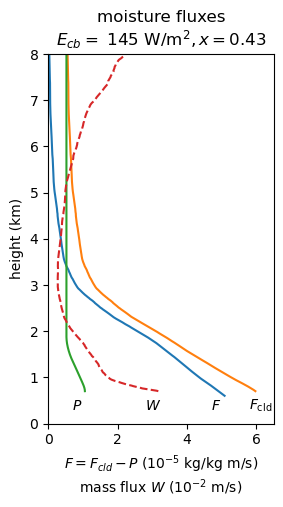

In [26]:
# compute cloud flux Fcld
Fcld = similarmissing(F)
Fcld[icb] = Ecb / rhoL # start at cloud base
x = 0.43
# ql defined above by the cloud model
cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb)
P = Fcld .- F # precip

# compute mass flux
W = Fcld ./ (qt .- qm) # m/s

# plot
clf()
subplot(1,2,1)
# cla()
# plot(F[[icb; icb:lastindex(F)]], z[[1; icb:lastindex(z)]]./1e3, label=L"F")
# plot(Fcld[[icb; icb:lastindex(F)]], z[[1; icb:lastindex(z)]]./1e3, label=L"F_{cld}")
# plot((Fcld.-F)[[icb; icb:lastindex(F)]], z[[1; icb:end]]./1e3, label=L"P")
plot(1e5*F, z./1e3, label=L"F")
plot(1e5*Fcld, z./1e3, label=L"F_{cld}")
plot(1e5*(Fcld.-F), z./1e3, label=L"P")
title("cloud mass flux")
plot([0,0], [0, 10], linewidth=0.5, color="k")
ylim([0, 8])
title("moisture fluxes\n\$E_{cb}=\$ $(Ecb) W/m\$^2, x=$(x)\$")
ylabel("height (km)")
xlabel(L"F = F_{cld} - P"*" (10\$^{-5}\$ kg/kg m/s)")
xlim([0, 6.5])
# legend(frameon=false)

# savefig("moisture_flux.eps")
# savefig("moisture_flux.png")
# savefig("moisture_flux.pdf")
# savefig("moisture_flux.svg")

# add mass flux to plot
plot(W*1e2, z/1e3, label=L"W", linestyle="--")
# plot([0,0], [0, 10], linewidth=0.75, linestyle="--", color="k", label="W")
xlabel(L"F = F_{cld} - P"*" (10\$^{-5}\$ kg/kg m/s)"*"\nmass flux \$W\$ (10\$^{-2}\$ m/s)")
# legend(frameon=false)
ylabel("height (km)")

text(2.8, 0.3, L"W")
text(4.7, 0.3, L"F")
text(5.8, 0.3, L"F_\text{cld}")
text(0.7, 0.3, L"P")

# savefig("mass_flux.eps")
# savefig("mass_flux.png")
# savefig("mass_flux.pdf")
# savefig("mass_flux.svg")

gcf()
# compute cloud-conditional updraft velocity
# wup = W ./ af

The vertical flux $F$ balances large scale advection and subsidence of moisture, mostly below 3 km. A strong moisture gradient extends the subsidence drying to the top of the trade cumulus layer at 2-3 km. The cloud and total eddy moisture flux balance this subsidence. Mass flux is mostly below 2 km. The strong difference between the dry environment and the cloud updraft, whose specific humidity is proportional to the saturation specific humidity, achieves the moisture flux at 2-3 km despite weak mass flux there.

Precipitation integrates downward proportional to cloud liquid water. Precipitation flux is strongly confined to low altitudes within the cloud layer, mostly to below 1.6 km.



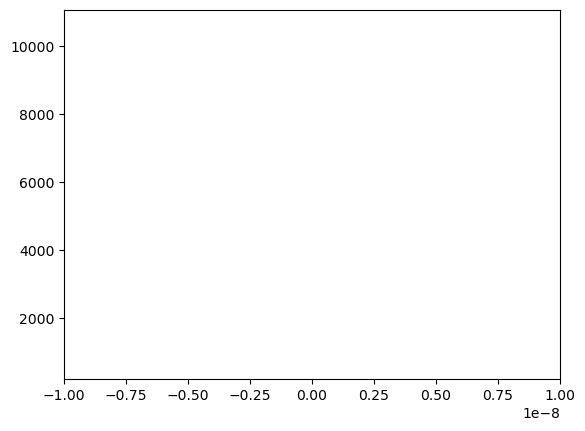

In [27]:
# precipitation sensitivity to pcp effic x
Fcld = similarmissing(F)
Fcld[icb] = Ecb / rhoL # start at cloud base
clf()
for x = 0.431847:0.00001:0.432
    qcb = qs[icb] # 0.01568
    qtilde = q_tilde(qm, qs, x)
    qtilde[1:icb] .= qcb # cloud base initial condition
    qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb, qtilde=qtilde)
    ql = max.(0, qt.-qs)

    cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb) # should go to zero at cloud top
    P = Fcld .- F # precip
    plot(P,z)
end
xlim([-1e-8, 1e-8])
gcf()

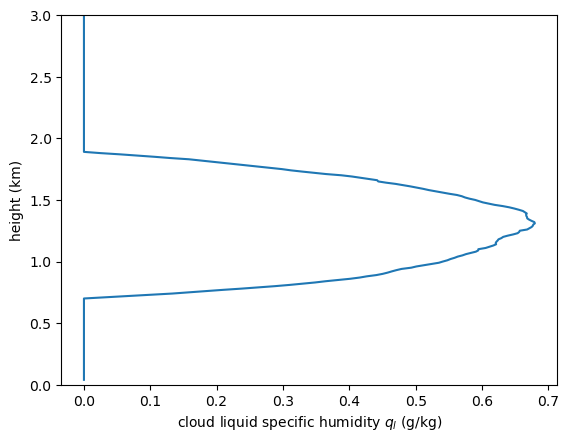

In [28]:
# plot cloud liquid specific humidity ql for control case
clf()
plot(1e3*ql, z/1e3)
ylim([0, 3])
ylabel("height (km)")
xlabel("cloud liquid specific humidity "*L"q_l"*" (g/kg)")
gcf()

In [29]:
maximum(ql[isfinite.(ql)]) # 0.0125 kg/kg
findall(ql .> 0.00001) # 0.0001 kg/kg

118-element Vector{Int64}:
  72
  73
  74
  75
  76
  77
  78
  79
  80
  81
   ⋮
 181
 182
 183
 184
 185
 186
 187
 188
 189

In [30]:
# find highest finite trade Cu cloud top from this model
zlim = 4e3
# functions find index of cloud maximum and cloud top, ignoring NaNs
cloudmax(a) = argmax(i-> isnan(a[i]) ? -9999 : a[i], eachindex(a))
cloudtop(a) = findfirst(a.<=0 .&& cloudmax(a).<eachindex(a))

qt_=q_total(dz*ae, x, qs, qm; qtilde=qtilde)
ql = max.(0,qt_.-qs)
plot(1e3*ql , z/1e3, color="k", linewidth=0.6)

# highest trade Cu cloud top from this model
# for α+ϵ=0.44 km^{-1}, at 3.6 km
clf()
# ae_hiBLCu = 4.415e-4 # 0.415 / km # 3.54 km
ae_hiBLCu = 5.23e-4 # 0.415 / km # 3.54 km
qt_=q_total(dz*ae_hiBLCu, x, qs, qm; qtilde=qtilde)
ql_ = qt_.-qs

# cloud heights
i = cloudmax(ql_)
j = cloudtop(ql_)
hiBLCumax = z[i]/1e3 # 3.54 km
hiBLCutop = z[j]/1e3 # 3.54 km

clf()
plot(1e3*ql_, z/1e3, color="tab:green", linewidth=0.6)
plot(1e3*ql_[i], z[i]/1e3, marker="x")
plot(1e3*ql_[j], z[j]/1e3, marker="o")
ylim([0,4])
ylabel("height (km)")
title("cloud liquid and top height\nfor different total sink rate α+ϵ")
# xlabel("cloud liquid specific humidity "*L"q_l"*" (g/kg)")

gcf()

UndefKeywordError: UndefKeywordError: keyword argument `i0` not assigned

In [31]:
# plot ql for different sink rates
aez = vcat(5.23e-4, 6e-4 : 3e-4 : 6e-3 ) # plot more cloud tops than ql profiles
zct = Array{Union{Float64,Missing}}(missing, size(aez))
# this works, but is sort of low resolution???
for i in eachindex(aez)
    aei = aez[i]
    qt_=q_total(dz*aei, x, qs, qm; qtilde=qtilde) # , stopattop=true) # doesn't work properly
    ql_=qt_.-qs 
    if any(ql_ .> 0) 
        zct[i] = z[cloudtop(ql_)] # already finds ql ≊ 0
    end # otherwise zct is missing
end

clf()
subplot(1,2,1)
# for ae = 5e-3 .* (0.5:-0.1:0.1)
# ae = vcat(4e-3:-4e-4:8e-4, 4.8e-4)
for i in eachindex(aez)
    ae = aez[i]
    qt_=q_total(dz*ae, x, qs, qm; qtilde=qtilde)
    ql_ = max.(0,qt_.-qs)
    plot(1e3*ql_, z/1e3, color="tab:green", linewidth=0.6)
end
# add control case
plot(1e3*ql, z/1e3, color="tab:green", linewidth=1.2)
ylim([0, 4])

# add cloud top to previous axis # clf()
plot(1e3*aez, [zct[1:end-1]/1e3; hiBLCutop], linewidth=1, marker=".", color="tab:blue")
# ylabel("cloud top height (km)")
xlabel("cloud liquid specific humidity "*L"q_l"*" (g/kg),\ntotal sink rate α+ϵ (km\$^{-1}\$)")
xlim([0, 5.25])
tight_layout()

# [ savefig("cloud_top_heights.$(f)", format=f) for f in ("eps","png","svg","pdf") ]
gcf()
# does not depend on precipitation efficiency

UndefKeywordError: UndefKeywordError: keyword argument `i0` not assigned

In [32]:
ae, x

(0.0015, 0.43)

## STOP control case here
Stuff after this might clobber control case parameters.

In [33]:
# test 
f999(x) = x == -999 ? NaN : x

clf()
ae = 4.414e-4 # 0.441 / km # 3.6 km
qt_=q_total(dz*ae, x, qs, qm; qtilde=qtilde)

plot(1e3*f999.(qt_), z/1e3, label="qt", linewidth=0.6)
plot(1e3*f999.(qs) , z/1e3, label="qs", linewidth=0.6)

ql = max.(0,qt_.-qs)
plot(1e3*ql , z/1e3, color="tab:green", label="ql", linewidth=0.6)
xlim([0, 2.5])
gcf()

UndefKeywordError: UndefKeywordError: keyword argument `i0` not assigned

A range of cloud liquid water and cloud top height is produced by varying the total entrainment and precipitation sink, $\epsilon + \alpha$ in Fig. CLOUDTOPHT. The lowest cloud from the model, with top at 690 m, is for a sink of $\epsilon+\alpha$ = 4 km $^{-1}$. Clouds vanish for any stronger a sink. The highest cloud top representative of trade cumulus clouds, at 3.6 km, is produced for $\epsilon+\alpha$ = 0.44 km $^{-1}$. Clouds with sink rate of less than 0.44 km $^{-1}$ transport water up and generate clouds to the full depth of the tropopause like deep convection, with a minimum cloud fraction at the 3.6 km trade inversion. The model neglects processes relevant to deep convection such as ice, buoyancy, latent heating, and radiation.

Cloud parcels are initialized with 16 g/kg to be nominally saturated at 600 m. They entrain immediately and cloud water autoconverts to precipitation. Total parcel specific humidity is compared to saturation humidity of the environment to determine cloud liquid water. The parcel is initialized to be saturated at 600 m, but the parcel may not exceed saturation until it is slightly higher because of its moisture sinks.

In [34]:
# lookup sink from cloud top by interpolation
# interpolate cloud top height vs. total sink rate

# ae is a scalar here, so broken
# ii = findall(.!ismissing.(zct) .& .!ismissing(ae))
# itp_ae = interpolate( ([Float64.(zct[ii]); 3600.0],), [ae[ii]; 4.413e-4], Gridded(Linear()) )
# itp_ae.(690:10:3600) # interpolated to z grid 690-3600 m

In [35]:
# Experiment 1: keep const RH, increase T

qs1 = qsat.(pm, tam.-KelvinCelsius .+ 1.0) # kg/kg
fac = qs1./qs # factor by which saturation specific humidity increases for +1 K
qm1 = fac .* qm # specific humidity for same RH after +1 K
# compute best q_T, ql for control case
# ae = 1.5e-3 # α+ϵ = 1.5 (km)^-1
qtilde = q_tilde(fac.*qm, qs1)
qtilde[1:54] .= fac[54]*qcb # cloud base initial condition
qt1 = q_total(dz*ae, x, qs1, qm1; qtilde=qtilde)

ql1 = max.(0, qt1.-qs1)

clf()
# plot control case
lw = 0.8
plot(1e3*qm, z/1e3, label=L"q", color="k", linewidth=lw)
plot(1e3*qs, z/1e3, label=L"q_s", color="k", linewidth=lw)
plot(1e3*qt, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=lw)
plot(1e3*ql, z/1e3, color="tab:green", linewidth=lw)
# plot experiment
lw = 1.5
plot(1e3*qm.*fac, z/1e3, label=L"q", color="k", linewidth=lw)
plot(1e3*qs1, z/1e3, label=L"q_s", color="k", linewidth=lw)
plot(1e3*qt1, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=lw)
plot(1e3*ql1, z/1e3, color="tab:red", linestyle=":", linewidth=lw)
ylim([0, 4])
ylabel("height (km)")
# legend(frameon=false)
xlabel("specific humidity (g/kg)")
# xlim([0,1])
title("Experiment 1: const. RH, ΔT=+1°C")
gcf()

# 1-mean(filter(isfinite, ql1./ql)) # 0.001248 = 0.12 %
# cloud liquid changes very little

MethodError: MethodError: no method matching q_tilde(::Vector{Float64}, ::Vector{Float64})
The function `q_tilde` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  q_tilde(::Any, ::Any, !Matched::Any)
   @ Main ~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB/sonde/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sdnNjb2RlLXJlbW90ZQ==.jl:13


In [36]:
# Experiment 2: keep const q, increase T

# qs1 = qsat.(pm, tam.-KelvinCelsius .+ 1.0) # kg/kg
qs2 = qs1
# fac = qs1./qs

# compute best q_T, ql for control case
# ae = 1.5e-3 # α+ϵ = 1.5 (km)^-1
qtilde = q_tilde(qm, qs2)
qtilde[1:54] .= fac[54]*qcb # cloud base initial condition
qt2 = q_total(dz*ae, x, qs2, qm; qtilde=qtilde)

ql2 = max.(0, qt2.-qs2)

clf()
# plot control case
lw = 0.8
plot(1e3*qm, z/1e3, label=L"q", color="k", linewidth=lw)
plot(1e3*qs, z/1e3, label=L"q_s", color="k", linewidth=lw)
plot(1e3*qt, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=lw)
plot(1e3*ql, z/1e3, color="tab:green", linewidth=lw)
# plot experiment 1
lw = 1.5
plot(1e3*qm.*fac, z/1e3, label=L"q", color="k", linewidth=lw)
plot(1e3*qs1, z/1e3, label=L"q_s", color="k", linewidth=lw)
plot(1e3*qt1, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy",linewidth=lw)
plot(1e3*ql1, z/1e3, color="tab:red", linestyle=":", linewidth=lw)
# plot experiment 2
lw = 1.5
plot(1e3*qm , z/1e3, label=L"q", color="k", linewidth=lw)
plot(1e3*qs2, z/1e3, label=L"q_s", color="k", linewidth=lw)
plot(1e3*qt2, z/1e3, label="α+ϵ=$(1e3*ae) km\$^{-1}\$", color="navy", linestyle="--", linewidth=lw)
plot(1e3*ql2, z/1e3, color="tab:pink", linestyle="-", linewidth=lw)
ylim([0, 4])
ylabel("height (km)")
# legend(frameon=false)
xlabel("specific humidity (g/kg)")
# xlim([0,1])
title("Experiment 1: const. RH,\n Experiment 2: const. \$q\$; ΔT=+1°C")
gcf()

# mean(filter(isfinite, ql2./ql)) # 0.4082 = 40.8 %
# entrainment of relatively drier qm dries the cloud out, resulting in a shallower drier cloud
# cloud liquid decreases to 40.8 % of the control case

MethodError: MethodError: no method matching q_tilde(::Vector{Float32}, ::Vector{Float64})
The function `q_tilde` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  q_tilde(::Any, ::Any, !Matched::Any)
   @ Main ~/Projects/ATOMIC/ATOMIC_GOES/julia/RHB/sonde/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X22sdnNjb2RlLXJlbW90ZQ==.jl:13


Naiive basic warming experiments seem to reduce the cloud depth and liquid water. The experiments assume the cloud ensemble has the same total water flux.

In [37]:
# Experiment 1:
# increase q_s(T) by adding constant dT0, 
# keep RH constant
# this enters in 2 places: increasing Δq, and making γ more negative
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg


3100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
   0.020221855067664496
   0.02011893947399997
   0.020018975640077152
   0.019922378957055998
   0.019828380330523983
   0.019733636265106207
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

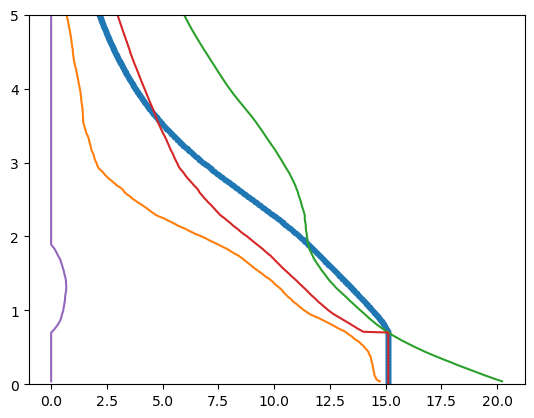

In [38]:

ql = max.(0, qt .- qs)

clf()
plot(1e3*qt, z/1e3, label=L"q_t", marker=".") # subsaturated everywhere
plot(1e3*qm, z/1e3, label=L"q")
plot(1e3*qs, z/1e3, label=L"q_s")
plot(1e3*qtilde, z/1e3)
plot(1e3*ql, z/1e3, label=L"q_l")
ylim([0, 5])
gcf()



\(q_s\) of the environment depends only on local \(T\).
Clouds have nearly the same temperature as their environment.
Clouds are saturated so they are close to \(q_s\).

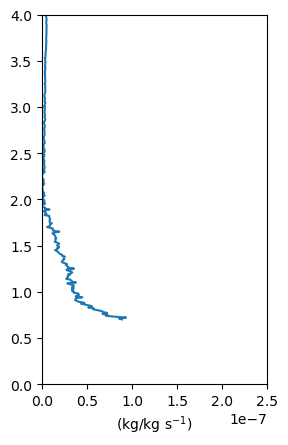

In [39]:
# total condensation
cond = -(1-x) * (W[1:end-1].+W[2:end])/2 .* dqsdz

clf()
subplot(1,2,1)
plot(cond, z[1:end-1]/1e3)
ylim([0,4])
xlim([0,2.5e-7])
xlabel("(kg/kg s\$^{-1}\$)")
gcf()

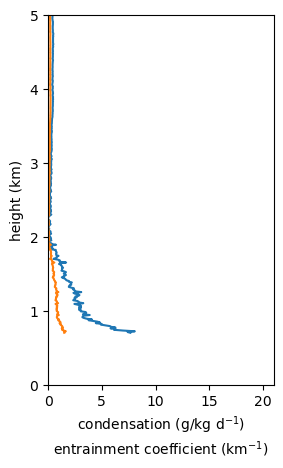

In [40]:
# entrainment coefficient 
# from the local Euleriean updraft model
entr_coeff = -dqsdz * (1-x) ./ ((Δq[1:end-1].+Δq[2:end])/2)

clf()
subplot(1,2,1)
plot(cond*86400*1e3, z[1:end-1]/1e3)
plot(entr_coeff[icb:end]*1e3, z[icb:end-1]/1e3)
ylim([0, 5])
xlim([0, 21])
xlabel("condensation (g/kg d\$^{-1}\$)\nentrainment coefficient (km\$^{-1}\$)")
ylabel("height (km)")

gcf()

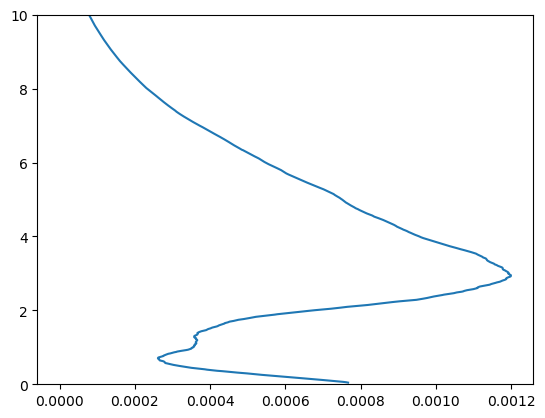

In [41]:
# ql model

#= requires an integration and doesn't work right
ql = similarmissing(qm)
ql[icb] = 0 # initial condition
aa = 1 - dz*(entr_coeff+pcp_coeff)/2
bb = 1 + dz*(entr_coeff+pcp_coeff)/2
c(i) = -dqsdz[i] + entr_coeff*(qm[i]+qm[i+1]-qs[i]-qs[i+1])/2
for i in icb:length(ql)-1 # march up z
    ql[i+1] = (ql[i]*aa + dz*c(i)) / bb
end
# plot(c.(1:(length(z)-1)), z[1:end-1]/1e3)
# not working, signs not right, check again for sign errors?
=#

# mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16
pcp_coeff = 2e-1
entr_coeff = 1e-1
relax_coeff = 1

# diagnostic ql
ql = -(dqsdz .+ entr_coeff*mid(qs.-qm)) / (entr_coeff+pcp_coeff - relax_coeff)

clf()
# subplot(1,2,1)
plot(ql, mid(z./1e3))
ylim([0,10])
# xlim([0, 0.01])
gcf()

# As local Eulerian dqsdz gets small, 
# nothing stops entrainment from exceeding it and
# making ql < 0. 

In [42]:
# plot the convective mass flux
clf()
# plot(massflux(qm[ii], z[ii]; dz=z[ii].-z[ii.-1]) .+ EmP/Δq, z[ii]/1e3)
# plot(-cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon)) .+ EmP/Δq, z[ii[1:end]]/1e3)
plot(-subsidence.(z)*1e3, z/1e3, linewidth=1, linestyle="--", label=L"\overline{w}")
plot(wstar*1e3, z[ii]/1e3, linewidth=2, label=L"w^*")
plot(qm*1e3, z/1e3, linewidth=0.4, label=L"q")
text(3.5, 9, L"-\overline{w}")
text(1, 3, L"q")
text(7, 3, L"w^*")
ylim(0, 10.0)
xlim(0, 30)
title("specific humidity (g kg\$^{-1}\$), convective mass flux \$w^*\$ (mm s\$^{-1}\$)")
ylabel("height (km)")

# savefig("massflux_atomic.pdf")
# savefig("massflux_atomic.png")
gcf()

# add constant of integration to match the surface (E-P)_0.

UndefVarError: UndefVarError: `wstar` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Figure MASSFLX. Specific humidity (green), subsidence (blue dashed), and convective mass flux (orange) for the trade cumulus boundary layer from moisture balance (equation ). A mass flux velocity $w^*$ = 25 mm s $^{-1}$ is equivalent to mean updrafts of 2.5 m s $^{-1}$ occupying 1% of the area.

In [43]:
# fit piecewise w* in trade Cu BL
clf()
plot(wstar*1e3, z[ii]/1e3, linewidth=2, label=L"w^*")

plot([27, 27, 21.5, 9, 9-12.5], [0, 0.55, 1.65, 2.65, 3.65])
plot([6.5], [2.85], marker="*")

# exponential fit above trade Cu BL
plot(6.5*exp.(-(0:0.2:7)./2.2), 2.85.+(0:0.2:7))
# plot(9.0*exp.(-(0:0.2:7)./1.5), 2.65.+(0:0.2:7)) # doesn't work as well

ylim(0, 10.0)
xlim(0, 30)
title("convective mass flux \$w^*\$ (mm s\$^{-1}\$)")
ylabel("height (km)")
# gcf()

UndefVarError: UndefVarError: `wstar` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Linear fit:
27 mm/s below 550 m

decreases 5.5/1.1 = 5 mm/s / km from 550 m to 1.65 km

decreases 12.5 mm/s / km to 6.5 mm/s at ~ 2.85 km.

## mass flux and updraft heights
Divergence of the mass flux with height implies the rate at which the ensemble of updrafts detrains their mass.
So for the nearly constant $w^*$ below cloud base, eddies carry moisture up to the cloud base without mass flux divergence.
For constant slope of mass flux divergence, an ensemble of updrafts with evenly distributed top heights detrain at a constant rate.

For the above layers this detrainment rate is 
$$
\delta = \left\{ \begin{array}{ll}
          \;\;5&\times 10^{-6} \;\mathrm{ s}^{-1}    & \mathrm{for\;0.55}  \geq z \geq \mathrm{1.65 km};\\
          12.5&\times 10^{-6} \;\mathrm{ s}^{-1} & \mathrm{for\;1.65}  \geq z \geq \mathrm{2.85 km}.
          \end{array} \right.
$$

Above 2.85 km the frequency of cloud top (detrainment) height decreases approximately exponentially with height, e-folding every 2.2 km.

What is the cdf of cloud top heights from GOES-16?

In [44]:
# load example GOES cloud image data
using ATOMIC_GOES.DataIO

# times of GOES images downloaded for ATOMIC
GOESdt = DateTime( "2020-01-15T00:00" ) : Minute(20) : DateTime( "2020-02-20T23:40" )
GOESdt = filter( ATOMIC_GOES.checkG, GOESdt )  # check that files exist

function get_clouds(dt)
    cth = sub( loadG( dt, "cloud_top_height" ) )
    tir = sub( loadG( dt, "temperature_ir" ) )
    refl = sub( loadG( dt, "reflectance_vis") )
    lwp = sub( loadG( dt, "cloud_lwp_iwp") )
    ph = sub( loadG( dt, "cloud_phase") )
    return cth, tir, refl, lwp, ph
end

cth, tir, refl, lwp, phase = get_clouds(DateTime( "2020-01-16T04:00" ))
lwp[ph.!=1] .= missing # non-liquid
# lwp[ph.==4] .= -1 # clear
# lwp[ph.==2] .= -99 # ice

ArgumentError: ArgumentError: Package ATOMIC_GOES not found in current path.
- Run `import Pkg; Pkg.add("ATOMIC_GOES")` to install the ATOMIC_GOES package.

In [45]:
size(lwp) # 502, 839
# length(1:251), length(252:502)
# 1:420, 421:839

vcat(CartesianIndices((1:420, 7:12))[:], CartesianIndex(8,12))

UndefVarError: UndefVarError: `lwp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [46]:
# plot GOES images
clf()
figure(figsize=(6,7))

subplot(4,1,1)
imshow(m2z(cth)[252:end,:], cmap=ColorMap("gray"), origin="lower",
    norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.6, vmin=0, vmax=3.5))
colorbar()
title("cloud top height \$h_{CT}\$ (km)")

subplot(4,1,2)
imshow(tir[252:end,:], cmap=ColorMap("gray_r"), origin="lower",
    norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.9, vmin=280))
colorbar()
title("IR brightness temperature \$T_{IR}\$ (K)")

subplot(4,1,3)
# imshow(refl.*replace(cth, missing=>0.55), cmap=ColorMap("gray"), origin="lower",
#     norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.5, vmax=2.0))
imshow(m2z(lwp)[252:end,:], cmap=ColorMap("gray"), origin="lower",
    norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.5, vmin=0, vmax=40))
colorbar()
# title("\$r\\ h_{CT}\$")
title("liquid water path LWP (g/m^2)")

# subplot(4,1,4)
# imshow(refl[252:end,:], cmap=ColorMap("gray"), origin="lower",
#     norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.5, vmax=1.0))
# colorbar()
# title("visible reflectance \$r\$")

pseudoarea(lwp,cth) = !ismissing(cth) && cth>0.05 ? lwp/15/cth : 0

subplot(4,1,4)
imshow(pseudoarea.(lwp,cth)[252:end,:], cmap=ColorMap("gray"), origin="lower",
    norm=PyPlot.matplotlib.colors.PowerNorm(gamma=0.5, vmin=0, vmax=3.0))
colorbar()
title("pseudo area")

tight_layout()

# savefig("")

gcf()

UndefVarError: UndefVarError: `cth` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Reflectance contrast shows more cumuliform and open cell structure, but is only available during daylight.

LWP does admirably at showing cell structure using near IR. It's available at night.

Cloud top height is indicated by cth. 
Use reflectance to indicate cloud fraction within pixels, which then scales the mass flux.

In [47]:
x = sort( m2z(cth)[1:1:end], rev=true )

figure(figsize=(8,4))
# plot the convective mass flux
subplot(1,2,1)
# plot(massflux(qm[ii], z[ii]; dz=z[ii].-z[ii.-1]) .+ EmP/Δq, z[ii]/1e3)
# plot(-cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon)) .+ EmP/Δq, z[ii[1:end]]/1e3)
plot(-subsidence.(z)*1e3, z/1e3, linewidth=1, linestyle="--", label=L"\overline{w}")
plot(wstar*1e3, z[ii]/1e3, linewidth=2, label=L"w^*")
plot(qm*1e3, z/1e3, linewidth=0.4, label=L"q")
text(3.5, 9, L"-\overline{w}")
text(1, 3, L"q")
text(7, 3, L"w^*")
ylim([0, 14.0])
xlim(0, 30)
title("specific humidity (g kg\$^{-1}\$)\nconvective mass flux \$w^*\$ (mm s\$^{-1}\$)")
ylabel("height (km)")
text(27, 13, "a")

subplot(1,2,2)
plot((1:length(x))/length(x), x)
plot([0.2, 0.5], 2.7.+[0,0])
ylim([0, 14])
xlim([0, 1])
title("GOES-E cloud top height distribution")
text(0.9, 13, "b")

# savefig("massFlux_cthCdf_14km.png")
# savefig("massFlux_cthCdf_14km.pdf")
# gcf()

UndefVarError: UndefVarError: `cth` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Trade Cu clouds below 2.7 km correspond well to the mode of the mass flux. They are the focus of this study.

Could say the higher clouds provide mass flux that is responsible for the compensating background subsidence we assumed, and maybe modifies it from its assumed value.

In [48]:
# zoom in  on lower 3 km
# move some labels

# x = sort( m2z(cth)[1:25:end], rev=true )

figure(figsize=(8,4))
# plot the convective mass flux
subplot(1,2,1)
# plot(massflux(qm[ii], z[ii]; dz=z[ii].-z[ii.-1]) .+ EmP/Δq, z[ii]/1e3)
# plot(-cumsum( wdqdz[ii] ) * dz / (Δq*(1-epsilon)) .+ EmP/Δq, z[ii[1:end]]/1e3)
plot(-subsidence.(z)*1e3, z/1e3, linewidth=1, linestyle="--", label=L"\overline{w}")
plot(wstar*1e3, z[ii]/1e3, linewidth=2, label=L"w^*")
plot(qm*1e3, z/1e3, linewidth=0.4, label=L"q")
# text(3.5, 9, L"-\overline{w}")
# text(1, 3, L"q")
# text(7, 3, L"w^*")
ylim([0, 3.0])
xlim(0, 30)
title("specific humidity (g kg\$^{-1}\$)\nconvective mass flux \$w^*\$ (mm s\$^{-1}\$)")
ylabel("height (km)")
text(27, 2.6, "a")

subplot(1,2,2)
plot((1:length(x))/length(x), x)
plot([0.2, 0.5], 2.7.+[0,0])
ylim([0, 3])
xlim([0.3, 0.7])
title("GOES-E cloud top height distribution")
text(0.65, 2.6, "b")

savefig("massFlux_cthCdf_3km.png")
savefig("massFlux_cthCdf_3km.pdf")
# gcf()

UndefVarError: UndefVarError: `wstar` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

30% of cloud top height pixels are 0.5 - 2.7 km, nearly evenly distributed in height. But they detrain net mass flux at a greater rate above 1.8 km, indicating that the clouds that remain above 1.8 km are carrying greater mass flux, and as they top out, they detrain that greater mass flux.

Plot mass flux per unit cloud fraction. Have to invert 
  fraction(height) --> height(fraction)
  w*(fraction) = w*(height(fraction))
This tells how strong w* to ascribe to each pixel, depending on its height.

bin the cloud top heights by fraction? the fractions by height?

## Cloud mass flux strength from the CDF
To construct cloud mass flux strength as a function of cloud top height $\hat z$, calculate
$$
\frac{\partial w^*}{\partial \hat z} \Big / \frac{\partial a}{\partial \hat z} \approx \frac{\Delta w^*}{\Delta \hat z} \Big / \frac{\Delta a}{\Delta \hat z}
$$
numerically by gridding $w^*(\hat z)$ and $a(\hat z)$ on consistent grid $\hat z$, differencing the gridded quantities, and dividing them.

### A refinement
Weight (multiply) the cloud fraction by an estimate of cloud area in each pixel from the solar reflectance $\min(r, 1)$.

This refinement only works during daylight. There might be other IR wavelengths that can stand in for reflectance at night.

In [49]:
# fractional area grid

"area of clouds within pixel, estimated from reflectance_vis"
a_in_pixl(refl) = max(0, min(1.0, refl))

# use radiosonde z grid, select finite and every 2
isgrid = @. (true || ii % 2 == 1) && (z[ii] .<= 10.0e3)

ascending = sortperm( m2z(cth)[1:1:end], rev=false ) # ascending height order
descending = reverse(ascending)
m2z(x) = replace( x, missing=>0 )
x = m2z( cth[descending] ) # assign clear (cth missing) scenes to cth=0

# count cumulative number of pixels with cth below each grid height, by whole pixels
idx_grid = [ findfirst(m2z(cth[ascending]).*1.0e3 .>= z) for z in z[ii[isgrid]] ] 
agrid = idx_grid ./ length(x) # fractional area by whole pixels

# weight the cloud height pixels by the fraction in each mpixel
a_pix_in_grid = cumsum(a_in_pixl.(refl)[ascending])[idx_grid] ./ length(x)

# mean updraft vel for entire grid pixel, sorted by cloud height
updraft_grid = -diff(wstar[isgrid]) ./ diff(agrid)
# mean updraft vel for cloudy area in pixel
updraft_in_grid = -diff(wstar[isgrid]) ./ diff(a_pix_in_grid)


UndefVarError: UndefVarError: `cth` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [50]:
# compute updrafts with z histograms, faster than sorts
zgrid = 0:0.010:10.0 # z[ii][isgrid] # 40:10:10000 m

"Counts x>= each zg and adds counts to c in-place."
function histo!(c, zg, x) 
    for x in x
        i = findlast( zg.<=x )
        c[i] += 1
    end
end
"histogram initializes c=zeros(size(zg)+1) and counts x>= each zg."
function histo(zg, x) 
    c = zeros(Int64, size(zg))
    histo!( c, zg, x )
    return c
end

"accumulate y in s, count in c by summing where x>=xg"
# indices of x match arrays in tuple y
# tuple y must match tuplicity of s,c
function accum!(s, c, xg, x, y=(x,), cond=y->true )
    for j in eachindex(x)
        i = findlast( xg.<=x[j] )
        for iy in eachindex(y) # loop through each array in tuple y
            f = cond(y[iy][j])
                s[iy][i] += ( f ? y[iy][j] : 0 )
                c[iy][i] += f
        end
    end
end
function accum(xg, x, y=(x,))
    s = zeros(Float64, size(xg))
    c = zeros(Int64, size(xg))
    accum!(s,c, xg, x, y)
    return s, c
end
# precondition x and expand zg to count all values of x
# in some bin defined by x>=zg.

count = histo(zgrid, m2z(cth))
clf()
plot(count[2:end-1]/sum(count), zgrid[2:end-1])
ylim([0, 10])
xlim([0, 0.0025])
title("cloud top height histogram")

UndefVarError: UndefVarError: `cth` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [51]:
# loop over several hours/day and compile histograms
# times of GOES images downloaded for ATOMIC
GOESdt = DateTime( "2020-01-15T00:00" ) : Hour(1) : DateTime( "2020-02-20T23:40" )
isdaylight(dt) = (6 <= hour(dt) <= 14)
GOESdt = filter( dt -> isdaylight(dt) && ATOMIC_GOES.checkG(dt), GOESdt )  # check that files exist

zgrid = 0:0.010:10.0 # km

if false # don't usually recalculate
    # counters
    sum_a_in_pix = zeros(Float64, size(zgrid))
    count_topheight = zeros(Int64, size(zgrid))
    for dt in GOESdt
        cth  = sub( loadG( dt, "cloud_top_height" ) )
        refl = sub( loadG( dt, "reflectance_vis") )
        a_in_pixl.(refl)

        # increment the counters, composite on zgrid
        accum!( (sum_a_in_pix,), (count_topheight,), 
                zgrid, m2z(cth), (a_in_pixl.(refl),), y->!ismissing(y))
    end

    save("area_hist.jld2", 
    Dict(
    "sum_a_in_pix"=>sum_a_in_pix,
    "count_topheight"=>count_topheight)
        )
    # => just under 4 minutes
else # just load from file
    D = load("area_hist.jld2")
    count_topheight = D["count_topheight"]
    sum_a_in_pix = D["sum_a_in_pix"]
end

UndefVarError: UndefVarError: `ATOMIC_GOES` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [52]:
# plot histograms
clf()
plot(1e2*count_topheight[2:end-1]/sum(count_topheight), zgrid[2:end-1])
plot(1e2*sum_a_in_pix[2:end-1]/sum(count_topheight), zgrid[2:end-1])
ylim([0, 10])
xlim([0, 0.22])
xlabel("%")
title("cloud top height histogram / 10 m vertical bins
count fraction of cloud height pixels (blue)
cloud area fraction (orange)")

UndefVarError: UndefVarError: `count_topheight` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [53]:
zgrid[ii[1:997]] # km
z[ii[1:997]] # 40, 50, ... m

go = 1:997 # grid_overlap
a_fraction = sum_a_in_pix[ii[go]] / sum(count_topheight)
updraft_in_cloud_grid = -diff(wstar)[go] ./ a_fraction

plot(updraft_in_cloud_grid, zgrid[ii[go]], marker=".", linewidth=0.2)
xlim([0, 0.5])
title("cloud-area average updraft")
xlabel("m/s")
ylabel("cloud top height")

UndefVarError: UndefVarError: `sum_a_in_pix` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [54]:
sum(a_fraction)

recurse(runningmean, replace(updraft_in_cloud_grid, Inf=>0.2), 3)
recurse(runningmean, updraft_in_cloud_grid, 3)

UndefVarError: UndefVarError: `a_fraction` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [55]:
# plot cloud area average updraft
plot(updraft_in_cloud_grid, zgrid[ii[go]], marker=".", linewidth=0.2)
# plot(recurse(runningmean, updraft_in_cloud_grid, 3), zgrid[ii[go[5:986]]])
# plot(recurse(x->runningmean(x,15), updraft_in_cloud_grid, 3), zgrid[ii[go[8:959]]])
plot(recurse(x->runningmean(x,15), updraft_in_cloud_grid, 3), zgrid[ii[go[23 .+ (1:952)]]])
# a nice functional form
plotf(z -> 0.19*z * exp(-(z/4)^2) , zgrid[ii[go]])
xlim([0, 1])
title("cloud-area average updraft")
xlabel("m/s")
ylabel("cloud top height")

UndefVarError: UndefVarError: `updraft_in_cloud_grid` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [56]:
# plot cloud fraction and derived updraft velocities
clf()
subplot(1,2,1)
plot(agrid, z[ii[isgrid]]/1.0e3)
plot(  a_pix_in_grid, z[ii[isgrid]]/1.0e3)
plot(5*a_pix_in_grid, z[ii[isgrid]]/1.0e3, linewidth=0.2, linestyle="--")
ylim([0, 10])
xlim([0, 1])
ylabel("height (km)")
title("fraction of clouds below height
pixel (blue)
sub-pixel (orange)")

subplot(1,2,2)
plot(updraft_grid[1:400], z[ii[isgrid][1:400]]/1.0e3, linewidth=0.4)
plot(updraft_in_grid[1:400], z[ii[isgrid][1:400]]/1.0e3, linewidth=0.2, marker=".", markersize=2)
title("updraft velocity (m/s)
by pixel count (blue)
by cloud area (orange)")
xlim([0, 1])
ylim([0, 10])

UndefVarError: UndefVarError: `agrid` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

BL clouds (0.5-2.7 km) are common but have low opacity (includes sub-pixel fractional area). 6-7 km altostratus clouds have relatively high opacity and/or fraction.
They are ice or mixed phase and sublimate slowly.

Cloud amount (left) is in the denominator of the calculated updraft velocity (right). 
When there are very few clouds or they have a very small area, updraft
velocity cannot be reliably estimated.

In [57]:
plot(updraft_grid[1:400], z[ii[isgrid][1:400]]/1.0e3, linewidth=0.2, marker=".", markersize=2)
# plot(updraft_in_grid[1:400], z[ii[isgrid][1:400]]/1.0e3, linewidth=0.2, marker=".", markersize=2)
title("updraft velocity (m/s)")

UndefVarError: UndefVarError: `updraft_grid` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Using the pixel updraft velocity $w(\hat h)$ as a function of its
cloud top height $\hat h$, 
and the pixel cloud area fraction $\hat a$ (from reflectance),
each pixel's mass flux is 
$$
\hat w^* = w(\hat h)\hat a
$$.
The pixel mass flux is the area-average velocity over the pixel.
It is the same at all heights, including cloud base.
It is distinct from the domain average mass flux solved above to balance the moisture budget. The sum of pixel mass fluxes equals the domain average mass flux.

Define a velocity potential $\phi$ for irrotational velocity ${\bf u} = \nabla\phi$.
Integrating continuity $\nabla\cdot{\bf u_3} = 0$ from the surface where $w=0$
we get the divergence $\nabla\cdot{\bf u}$ from the vertical mass flux,
$$
-\nabla^2\phi = -\nabla\cdot{\bf u} = \frac{\hat w^*}{z_{CB}}.
$$